To create this algorithm, we combined three different datasets which included voice recordings and their respective labels- Happy, Sad, Angry, Calm etc. The datasets we used are RAVDESS, TESS and SAVEE.

Using Librosa, which we mentioned earlier, we managed to plot the raw display of one of our sound waves:

Then we displayed the same signal in a time-frequency domain, so that we could examine the different frequencies and amplitudes of our signal over time. This is done by performing the Fourier transformation on our data:

we plot a color map

later now, we plot linear representation of our frequencies over time, doesn’t seem to give us too much valuable information. The reason for that is that human can only hear sounds which are concentrated in a very small frequency and amplitude ranges (unlike dogs, for example). To fix that, we applied log-scale on both the frequency and the amplitudes. Note that after applying log-scale on our data, we’re no longer measuring our signal in units of amplitudes, but rather in units of decibels.

we plot a color map from amplitude vs time to decibles(magnitude) vs time

frequency(hz) vs time plot is called ---> spectrogram (The Spectrograms alone are also proven to be incredibly useful in classifying emotions thanks to their ability to approximate human-based perception of sounds)

now lets plot magnitude(db) vs frequency(hz) ---> log-scale spectrum === The log-scale spectrum is achieved by applying Fourier transformation on our data

The difference between Spectrograms and log-scale spectrums, which are both being achieved by similar mathematical operations, is that while the first displays the frequencies and decibels over time, the latter shows the relation between the decibels and the frequencies.

Now let’s consider a smoother version of our log-scaled spectrum ---> the Spectral envelope, This Spectral envelope is the equivalent of what we considered as the Vocal Tract, and its maximum points are called ‘Formants’. These peaks contain the main ‘identity’ of the sound and are considered as the most important parts of our sound wave. 

The reason for all that confusion is pretty simple- using our new Cepstrum and Quefrencies we can differentiate easily between our Spectral envelope (the Vocal Tract) and the noise (the Glottal Pulse). More then that, the Discrete Cosine transformation already results in the main and most important coefficients of this cepstrum- the Mel-frequency cepstrum coefficients, also known as the MFCC’s!

In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
def extract_features(file_name, mfcc, chroma, mel, spec):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        
        result=np.array([])
        
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        
        if chroma:
            stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
            
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
            
        if spec:
            spec=np.mean(librosa.feature.spectral_contrast(y=X,sr=sample_rate).T,axis=0)
            result=np.hstack((result,spec))
    
    return result

In [3]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
observed_emotions=['surprised', 'happy', 'disgust', 'fearful','neutral']

In [4]:
def load_data(test_size=0.2):
    x,y=[],[]
    
    for file in glob.glob("/Users/adithyaram/Downloads/speech_data//Actor_*//*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_features(file, mfcc=True, chroma=True, mel=True, spec=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)


In [5]:
x_train,x_test,y_train,y_test=load_data(test_size=0.15)

In [6]:
print("x-shape-trian:",x_train.shape[0])
print("x-shape-test:",x_test.shape[0],"\n")
print(np.array(x_train),"\n","\n")
print(np.array(x_test))

x-shape-trian: 734
x-shape-test: 130 

[[-615.6618042    50.17625046  -12.95750618 ...   17.63017455
    16.76444761   16.7369676 ]
 [-499.81567383   34.99504471  -11.95559502 ...   16.50211295
    17.56317981   15.67921249]
 [-444.01861572   32.2682724    -5.57420683 ...   16.97642817
    17.27541482   15.72510261]
 ...
 [-581.3692627    29.94678688  -10.25838661 ...   18.42369194
    18.46919159   15.79923743]
 [-428.074646     41.06212234   -9.95244884 ...   17.14745897
    17.52916123   16.88109798]
 [-630.92913818   47.32865906  -10.7452383  ...   16.90032502
    16.68732187   15.24676924]] 
 

[[-5.77806458e+02  5.26666222e+01  6.66469431e+00 ...  1.59387368e+01
   1.59024043e+01  1.48205548e+01]
 [-4.67137848e+02  2.13247051e+01 -3.79115562e+01 ...  1.85559734e+01
   2.00075660e+01  1.65397273e+01]
 [-4.45043121e+02  3.17270775e+01  6.09083605e+00 ...  1.57261794e+01
   1.61046837e+01  1.54976765e+01]
 ...
 [-5.88358276e+02  3.35062943e+01 -2.07160378e+01 ...  1.76126057e+01
   

In [7]:
print("Features extracted:", x_train.shape[1])

Features extracted: 187


In [13]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=600)

In [14]:
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=600)

In [15]:
y_pred=model.predict(x_test)

In [16]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.5f}%".format(accuracy*100))

Accuracy: 69.23077%


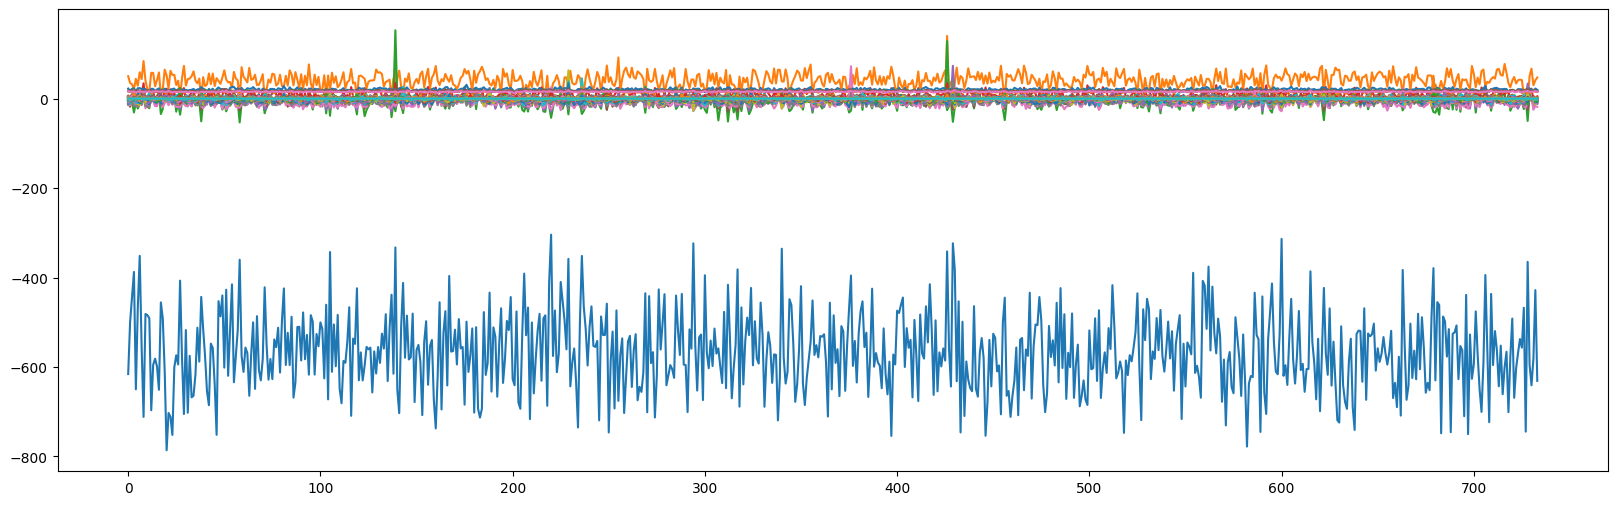

In [12]:
plt.figure(figsize=(20,6))
plt.plot(x_train)
plt.show()